In [2]:
!pip install -q sentence-transformers

import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import re

from google.colab import files
uploaded = files.upload()

df = pd.read_csv("susp_docs_cleaned.csv")

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"[^\w\s]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

df["cleaned_text"] = df["cleaned_text"].apply(clean_text)

df.head()


Saving susp_docs_cleaned.csv to susp_docs_cleaned.csv


,susp_doc,cleaned_text
0,We examined a multi-armed bandit with a limite...,we examined a multiarmed bandit with a limited...
1,"In an attempt to realize its ambitious goal, W...",in an attempt to realize its ambitious goal wo...
2,Ellen was shopping with her parents at the gro...,ellen was shopping with her parents at the gro...
3,"We show that, for a large class of piecewise ...",we show that for a large class of piecewise sm...
4,"Cruise, the self-driving car subsidiary of Gen...",cruise the selfdriving car subsidiary of gener...


from matplotlib import pyplot as plt
import seaborn as sns
_df_0.groupby('susp_doc').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_1.groupby('cleaned_text').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['cleaned_text'].value_counts()
    for x_label, grp in _df_2.groupby('susp_doc')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('susp_doc')
_ = plt.ylabel('cleaned_text')

In [4]:
model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")
embeddings = model.encode(df["cleaned_text"].tolist(), show_progress_bar=True)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/34 [00:00<?, ?it/s]

In [7]:
from sentence_transformers import SentenceTransformer
import pandas as pd

df = pd.read_csv("susp_docs_cleaned.csv")
model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

embeddings = model.encode(df["cleaned_text"].tolist(), show_progress_bar=True)

pd.DataFrame(embeddings).to_csv("sbert_embeddings.csv", index=False)
print("✅ Готово: sbert_embeddings.csv")


Batches:   0%|          | 0/34 [00:00<?, ?it/s]

✅ Готово: sbert_embeddings.csv


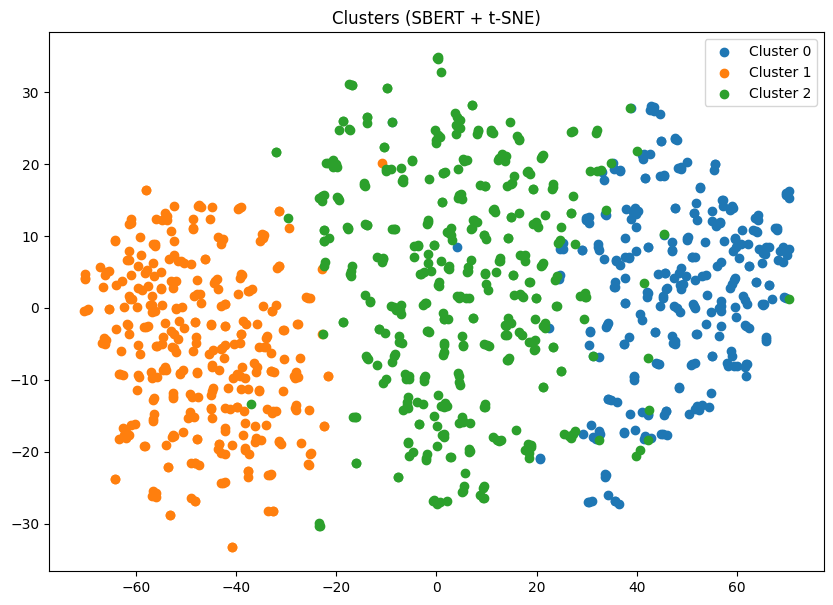

In [11]:
tsne = TSNE(n_components=2, random_state=42)
emb_2d = tsne.fit_transform(embeddings)


n_clusters = 3

kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
df["cluster"] = kmeans.fit_predict(embeddings)

plt.figure(figsize=(10, 7))
for cluster in range(n_clusters):
    subset = emb_2d[df["cluster"] == cluster]
    plt.scatter(subset[:,0], subset[:,1], label=f"Cluster {cluster}")
plt.legend()
plt.title("Clusters (SBERT + t-SNE)")
plt.show()

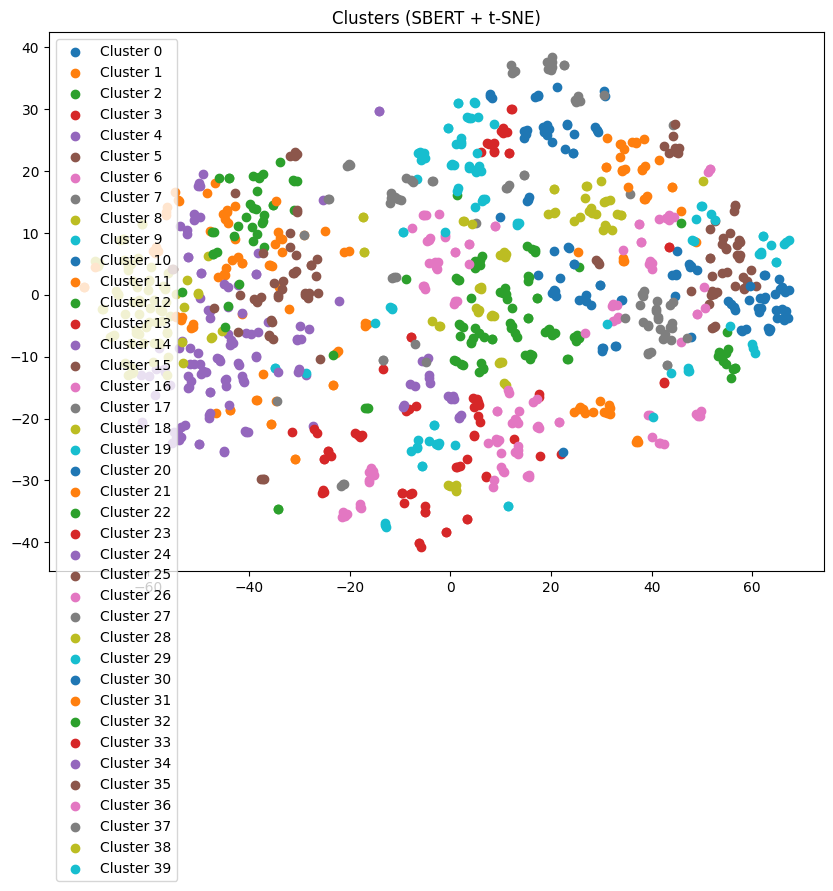

In [8]:
tsne = TSNE(n_components=2, random_state=42)
emb_2d = tsne.fit_transform(embeddings)

n_clusters = 40

kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
df["cluster"] = kmeans.fit_predict(embeddings)

plt.figure(figsize=(10, 7))
for cluster in range(n_clusters):
    subset = emb_2d[df["cluster"] == cluster]
    plt.scatter(subset[:,0], subset[:,1], label=f"Cluster {cluster}")
plt.legend()
plt.title("Clusters (SBERT + t-SNE)")
plt.show()

In [9]:
df[["cleaned_text", "cluster"]].to_csv("sbert_clusters.csv", index=False)
files.download("sbert_clusters.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [10]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import pandas as pd

embedding_df = pd.read_csv("sbert_embeddings.csv")
embeddings = embedding_df.values

dbscan = DBSCAN(eps=1.0, min_samples=5, metric='euclidean')
labels = dbscan.fit_predict(embeddings)

valid_mask = labels != -1
valid_embeddings = embeddings[valid_mask]
valid_labels = labels[valid_mask]

n_clusters_dbscan = len(set(valid_labels))
sil_score = silhouette_score(valid_embeddings, valid_labels) if n_clusters_dbscan > 1 else None

print(f"Clusters founded: {n_clusters_dbscan}")
print(f"Silhouette Score: {sil_score}")


Найдено кластеров: 40
Silhouette Score: 0.13627713743818173
